# 4_Plume_Analysis

In [12]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plume_learn.plume_utils.viz import show_images, label_violinplot
from plume_learn.plume_utils.manage_plume import remove_all_0_plume, load_json
from plume_learn.plume_analyzer.PlumeDataset import plume_dataset
from m3util.viz.layout import layout_fig
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines
from sro_sto_plume.modify_df import modify_df
from matplotlib import colormaps
colors = colormaps.get_cmap('tab10').colors[:6]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Plume data

### 1.1 load experiment conditions

In [2]:
sample_names = ['t1', 't2', 't3', 't4', 't5']
sample_ids = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069']
plume_recording_root = '../data/Plumes/plume_recordings/'
output_root = '../data/Plumes/plume_metrics/'

### 1.2 load metrics for every plume frame

In [5]:
df_frame_metrics = []
for id, growth_name in zip(sample_ids, sample_names):
    file = glob.glob(f'{output_root}/{id}*metrics.csv')[0]
    df = pd.read_csv(file)
    df_processed = modify_df(df)
    df_frame_metrics.append(df_processed)
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics

C:\Users\yig319\AppData\Local\Temp\ipykernel_31860\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_31860\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_31860\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_31860\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_31860\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Plume Index,Time (µs),Distance (m),Velocity (m/s),Area (a.u.),Threshold,Sample Name,Sample ID
0,0,0.0,0.000000,0.000000,0.0,200,t1,YG065
1,0,0.5,0.000000,0.000000,0.0,200,t1,YG065
2,0,1.0,0.008715,17429.394813,2074.0,200,t1,YG065
3,0,1.5,0.014784,12138.328530,3144.0,200,t1,YG065
4,0,2.0,0.021476,13383.285303,9039.0,200,t1,YG065
...,...,...,...,...,...,...,...,...
232827,287,61.5,0.032680,0.000000,0.0,200,t5/s1,YG069
232828,287,62.0,0.032680,0.000000,0.0,200,t5/s1,YG069
232829,287,62.5,0.032680,0.000000,0.0,200,t5/s1,YG069
232830,287,63.0,0.032680,0.000000,0.0,200,t5/s1,YG069


### 1.3 calculate max area and incident velocity

In [8]:
# analyze the max area
idx = df_frame_metrics.groupby(['Sample Name', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Sample Name', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)

# analyze plume Velocity that can be tracked before landing on the substrate
## calculate the velocity between 2.8cm and 2.9cm for the incident velocity
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 0.029) & (df_frame_metrics['Distance (m)'] <= 0.030)] 
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Sample Name', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Sample Name', 'Plume Index'])
df_plume_metrics.sample(5)

,Sample Name,Plume Index,Time at Max Area (µs),Max Area (a.u.),Incident Velocity (m/s)
808,t5/s1,199,3.0,16054.0,5291.066282
664,t4,226,3.0,16167.0,5602.305476
352,t2,296,3.0,16100.0,4357.348703
71,t1,171,3.0,16124.0,5291.066282
619,t4,120,3.0,15759.0,5291.066282


## 2. Introduction to Plume Dynamics Analysis

### 2.1 Load plumes

In [9]:
file = f'{plume_recording_root}/YG065_YichenGuo_09102024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
plumes = plume_ds.load_plumes('1-SrRuO3')

### 2.3 Violin Plot of Plume Max Area and Incident Velocity Statics

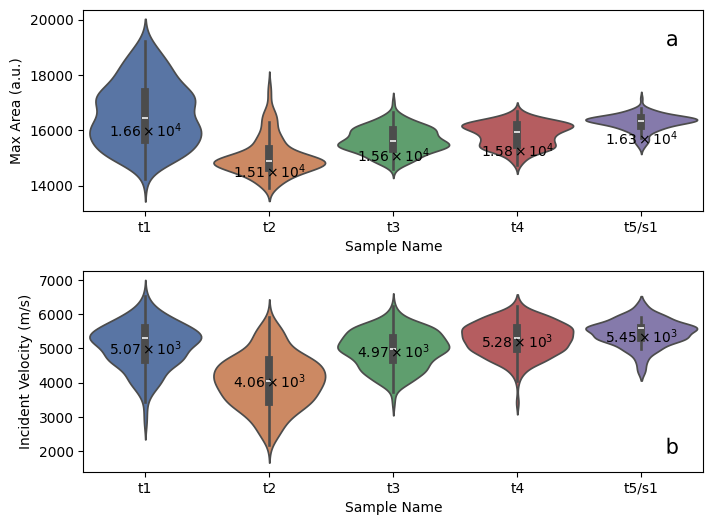

In [13]:
fig, axes = layout_fig(2, 1, figsize=(8, 6), subplot_style='gridspec', spacing=(0, 0.3), layout='tight')

sns.violinplot(x='Sample Name', y='Max Area (a.u.)', data=df_plume_metrics, width=0.9, ax=axes[0], palette='deep', hue='Sample Name', legend=False)

mean_max_area = df_plume_metrics.groupby('Sample Name')['Max Area (a.u.)'].mean()
label_violinplot(axes[0], mean_max_area, label_type='average_value', text_pos='center', value_format='scientific', text_size=10, offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.05})

labelfigs(axes=axes[0], number=0, size=15, style='bw', loc='tr', inset_fraction=(0.15, 0.05))

sns.violinplot(x='Sample Name', y='Incident Velocity (m/s)', data=df_plume_metrics, width=0.9, ax=axes[1], palette='deep', hue='Sample Name', legend=False)

mean_incident_velocity = df_plume_metrics.groupby('Sample Name')['Incident Velocity (m/s)'].mean()
label_violinplot(axes[1], mean_incident_velocity, label_type='average_value', text_pos='center', value_format='scientific', text_size=10, offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.05})

labelfigs(axes=axes[1], number=1, size=15, style='bw', loc='br', inset_fraction=(0.12, 0.05))

plt.savefig('../figures/5-Plume_metrics_violinplot.png', dpi=600, bbox_inches='tight')
# plt.savefig('../figures/4_Plume_metrics_violinplot.svg', dpi=600)
plt.show()